This notebook is to try out different architectures of NNs

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? н
Once deleted, variables cannot be recovered. Proceed (y/[n])? н
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from functions import *
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
from optparse import OptionParser
import matplotlib
matplotlib.use('Agg')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping

%matplotlib inline

/nfs/scistore08/kondrgrp/eputints/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# 1. Training NN for a single chunk

In [13]:
min_max_scaler = MinMaxScaler()
n_iter = 500

chunk = 'S2'
print (chunk)
data, labels, unique_mutations[chunk], aa_seq, mutlist = read_data_all_positions(chunk)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(1,input_dim=data.shape[1],kernel_initializer='glorot_normal'))
# model.add(Dense(20,activation='sigmoid'))
# model.add(Dense(1,activation='sigmoid'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

early_stopping_monitor=EarlyStopping(patience=20)

model.compile(optimizer=opt,
              loss='mean_squared_error')

hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, callbacks=[early_stopping_monitor],verbose=1)

proba = model.predict_proba(data, batch_size=500)

weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

true = labels
predicted = min_max_scaler.inverse_transform(proba)
predicted = predicted.flatten()
fitness_potential = data.dot(weights) + biases

S2
Train on 45200 samples, validate on 457 samples
Epoch 1/500
45200/45200 [==============================] - 0s - loss: 0.1171 - val_loss: 0.0571
Epoch 2/500
45200/45200 [==============================] - 0s - loss: 0.0484 - val_loss: 0.0586
Epoch 3/500
45200/45200 [==============================] - 0s - loss: 0.0483 - val_loss: 0.0633
Epoch 4/500
45200/45200 [==============================] - 0s - loss: 0.0482 - val_loss: 0.0361
Epoch 5/500
45200/45200 [==============================] - 0s - loss: 0.0478 - val_loss: 0.0502
Epoch 6/500
45200/45200 [==============================] - 0s - loss: 0.0477 - val_loss: 0.0403
Epoch 7/500
45200/45200 [==============================] - 0s - loss: 0.0490 - val_loss: 0.0405
Epoch 8/500
45200/45200 [==============================] - 0s - loss: 0.0477 - val_loss: 0.0652
Epoch 9/500
45200/45200 [==============================] - 0s - loss: 0.0484 - val_loss: 0.0529
Epoch 10/500
45200/45200 [==============================] - 0s - loss: 0.0477 - val_l

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


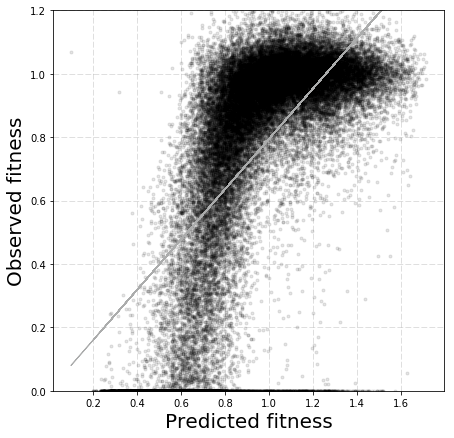

In [14]:
plt.figure(figsize = [7,7])
y = true
x = predicted
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=20)
plt.ylabel('Observed fitness', fontsize=20);

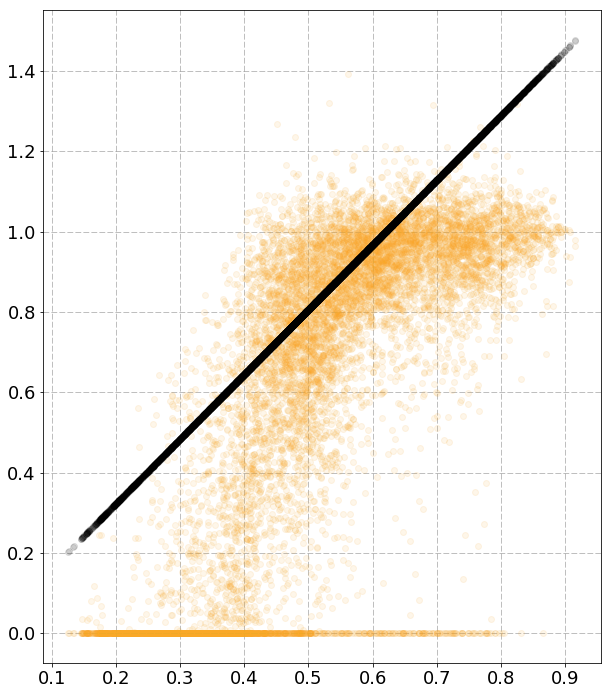

In [15]:
plt.figure(figsize=[10,12])
r=r2_score(labels,predicted)
# plt.title('Segment '+chunk[1:]+', R2=%.2f' % r,fontsize=30)
X = fitness_potential[:10000]
Y = true[:10000]
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(X, Y, 'o', alpha = 0.1, color='#F9A828')
plt.plot(X, predicted[:10000], 'o', c='k', alpha = 0.1)
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
# plt.savefig('../tmp/fp_'+chunk+'.png')

In [16]:
r

0.2157710461561927

In [17]:
slope, intercept, r_value, p_value, std_err = stats.linregress(true,predicted)
r_value

0.7164646049344453

# 2. Training all the segments with the chosen architecture

#### 2.1. Training

In [31]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
old_weights = {}
biases = {}
aa_seq = {}
unique_mutations = {}
mut_list = {}

In [32]:
min_max_scaler = MinMaxScaler()
n_iter = 100
r2_train={}
r2_val={}

for chunk in chunks:
    print (chunk)
    data, labels, unique_mutations[chunk], aa_seq[chunk], mut_list[chunk] = read_data_all_positions(chunk)
    
    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))
    
    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.05)
    it=0
    loop_count=10
    
    r2_train[chunk]=[]
    r2_val[chunk]=[]
    
    while it<loop_count and loop_count<100:

        print it, chunk
        model = Sequential()

        model.add(Dense(1,input_dim=data.shape[1],activation='sigmoid',kernel_initializer='glorot_normal'))
        model.add(Dense(20,activation='sigmoid'))
        model.add(Dense(1,activation='sigmoid'))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        early_stopping_monitor=EarlyStopping(patience=20)

        model.compile(optimizer=opt,
                      loss='mean_squared_error')

        hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                                epochs=n_iter, batch_size=500, shuffle=True, callbacks=[early_stopping_monitor],verbose=1)

        proba = model.predict_proba(data, batch_size=500, verbose=0)

        weights[chunk] = model.layers[0].get_weights()[0]
        biases[chunk] = model.layers[0].get_weights()[1]

        true[chunk] = scaledLabels
#         predicted[chunk] = min_max_scaler.inverse_transform(proba)
        predicted[chunk] = proba.flatten()
        fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]
        
        proba = model.predict_proba(x_valid, batch_size=500, verbose=0)
        temp_mse_val = mean_squared_error(y_valid,proba.flatten())
        
        it+=1
        
        if temp_mse_val>0.05 and chunk!='S9':
            print temp_mse_val
            loop_count+=1
            
        elif temp_mse_val>0.06 and chunk=='S9':
            loop_count+=1
            
        else:
            proba = model.predict_proba(x_train, batch_size=500, verbose=0)
            r2_train[chunk].append(r2_score(y_train,proba.flatten()))
            
            proba = model.predict_proba(x_valid, batch_size=500, verbose=0)
            r2_val[chunk].append(r2_score(y_valid,proba.flatten()))

S1
0 S1
Train on 55162 samples, validate on 2904 samples
Epoch 1/100
55162/55162 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0174
Epoch 2/100
55162/55162 [==============================] - 0s - loss: 0.0124 - val_loss: 0.0107
Epoch 3/100
55162/55162 [==============================] - 0s - loss: 0.0097 - val_loss: 0.0113
Epoch 4/100
55162/55162 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0099
Epoch 5/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0112
Epoch 6/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0104
Epoch 7/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0096
Epoch 8/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0110
Epoch 9/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0108
Epoch 10/100
55162/55162 [==============================] - 0s - loss: 0.0091 -

55162/55162 [==============================] - 0s - loss: 0.0100 - val_loss: 0.0129
Epoch 4/100
55162/55162 [==============================] - 0s - loss: 0.0095 - val_loss: 0.0100
Epoch 5/100
55162/55162 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0097
Epoch 6/100
55162/55162 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0101
Epoch 7/100
55162/55162 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0106
Epoch 8/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0114
Epoch 9/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0099
Epoch 10/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0097
Epoch 11/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0104
Epoch 12/100
55162/55162 [==============================] - 0s - loss: 0.0092 - val_loss: 0.0103
Epoch 13/100
55162/55162 [=======================

55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0096
Epoch 31/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0129
Epoch 32/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0127
Epoch 33/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0101
Epoch 34/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0098
Epoch 35/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0119
Epoch 36/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0095
Epoch 37/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0115
Epoch 38/100
55162/55162 [==============================] - 0s - loss: 0.0091 - val_loss: 0.0107
Epoch 39/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0096
Epoch 40/100
55162/55162 [=================

55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0097
Epoch 45/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0099
Epoch 46/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0100
Epoch 47/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0115
Epoch 48/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0095
Epoch 49/100
55162/55162 [==============================] - 0s - loss: 0.0089 - val_loss: 0.0126
Epoch 50/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0127
Epoch 51/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0111
Epoch 52/100
55162/55162 [==============================] - 0s - loss: 0.0089 - val_loss: 0.0096
Epoch 53/100
55162/55162 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0108
Epoch 54/100
55162/55162 [=================

43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0158
Epoch 12/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0157
Epoch 13/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0159
Epoch 14/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0167
Epoch 15/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0158
Epoch 16/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0158
Epoch 17/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0166
Epoch 18/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0159
Epoch 19/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0171
Epoch 20/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0159
Epoch 21/100
43374/43374 [=================

43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0159
Epoch 25/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0158
Epoch 26/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0157
Epoch 27/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0164
Epoch 28/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0162
Epoch 29/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0174
Epoch 30/100
43374/43374 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0167
Epoch 31/100
43374/43374 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0159
Epoch 32/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0158
Epoch 33/100
43374/43374 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0161
Epoch 34/100
43374/43374 [=================

45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0073
Epoch 44/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0072
Epoch 45/100
45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0086
Epoch 46/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0075
Epoch 47/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0073
Epoch 48/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0080
1 S3
Train on 45788 samples, validate on 2410 samples
Epoch 1/100
45788/45788 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0151
Epoch 2/100
45788/45788 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0096
Epoch 3/100
45788/45788 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0079
Epoch 4/100
45788/45788 [==============================] - 0s - loss: 0.0078 - val_loss: 

45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0076
Epoch 66/100
45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0074
Epoch 67/100
45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0073
Epoch 68/100
45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0073
Epoch 69/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0073
4 S3
Train on 45788 samples, validate on 2410 samples
Epoch 1/100
45788/45788 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0165
Epoch 2/100
45788/45788 [==============================] - 0s - loss: 0.0117 - val_loss: 0.0095
Epoch 3/100
45788/45788 [==============================] - 0s - loss: 0.0087 - val_loss: 0.0082
Epoch 4/100
45788/45788 [==============================] - 0s - loss: 0.0081 - val_loss: 0.0076
Epoch 5/100
45788/45788 [==============================] - 0s - loss: 0.0078 - val_loss: 0

45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0074
Epoch 27/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0081
Epoch 28/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0076
Epoch 29/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0074
Epoch 30/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0075
Epoch 31/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0074
Epoch 32/100
45788/45788 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0073
Epoch 33/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0075
Epoch 34/100
45788/45788 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0073
8 S3
Train on 45788 samples, validate on 2410 samples
Epoch 1/100
45788/45788 [==============================] - 0s - loss: 0.0283 - val_los

42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0052
Epoch 52/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0054
Epoch 53/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0055
Epoch 54/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0055
Epoch 55/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0075
Epoch 56/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0044
Epoch 57/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0053
Epoch 58/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0082
1 S4
Train on 42042 samples, validate on 2213 samples
Epoch 1/100
42042/42042 [==============================] - 0s - loss: 0.0438 - val_loss: 0.0314
Epoch 2/100
42042/42042 [==============================] - 0s - loss: 0.0168 - val_loss

42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0068
Epoch 20/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0070
Epoch 21/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0050
Epoch 22/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0062
Epoch 23/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0051
Epoch 24/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0048
Epoch 25/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0055
Epoch 26/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0068
Epoch 27/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0061
Epoch 28/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0058
Epoch 29/100
42042/42042 [=================

42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0055
Epoch 32/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0046
Epoch 33/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0055
Epoch 34/100
42042/42042 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0046
Epoch 35/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0063
Epoch 36/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0045
Epoch 37/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0059
Epoch 38/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0050
Epoch 39/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0069
Epoch 40/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0066
Epoch 41/100
42042/42042 [=================

42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0048
Epoch 35/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0053
Epoch 36/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0061
Epoch 37/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0045
Epoch 38/100
42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0053
Epoch 39/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0048
Epoch 40/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0055
Epoch 41/100
42042/42042 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0057
7 S4
Train on 42042 samples, validate on 2213 samples
Epoch 1/100
42042/42042 [==============================] - 1s - loss: 0.0424 - val_loss: 0.0278
Epoch 2/100
42042/42042 [==============================] - 0s - loss: 0.0172 - val_loss

42042/42042 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0050
S5
0 S5
Train on 48565 samples, validate on 2557 samples
Epoch 1/100
48565/48565 [==============================] - 1s - loss: 0.0087 - val_loss: 0.0081
Epoch 2/100
48565/48565 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0093
Epoch 3/100
48565/48565 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0068
Epoch 4/100
48565/48565 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0069
Epoch 5/100
48565/48565 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0056
Epoch 6/100
48565/48565 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0054
Epoch 7/100
48565/48565 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0055
Epoch 8/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0055
Epoch 9/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.

48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0061
Epoch 18/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0062
Epoch 19/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0055
Epoch 20/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0057
Epoch 21/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0062
Epoch 22/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 23/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0066
Epoch 24/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 25/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0057
Epoch 26/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0058
Epoch 27/100
48565/48565 [=================

48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 48/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 49/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0052
Epoch 50/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0057
Epoch 51/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0052
Epoch 52/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 53/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0053
Epoch 54/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 55/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0056
Epoch 56/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0056
Epoch 57/100
48565/48565 [=================

48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0056
Epoch 62/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0060
Epoch 63/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 64/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0052
Epoch 65/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0054
Epoch 66/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0062
Epoch 67/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0054
Epoch 68/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0053
Epoch 69/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0057
Epoch 70/100
48565/48565 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0061
Epoch 71/100
48565/48565 [=================

48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0059
Epoch 9/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 10/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0092
Epoch 11/100
48565/48565 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 12/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0053
Epoch 13/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 14/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0061
Epoch 15/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0054
Epoch 16/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0060
Epoch 17/100
48565/48565 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0054
Epoch 18/100
48565/48565 [==================

43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0162
Epoch 28/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0195
Epoch 29/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0175
Epoch 30/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0223
Epoch 31/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0164
Epoch 32/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0150
Epoch 33/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0168
Epoch 34/100
43016/43016 [==============================] - 0s - loss: 0.0136 - val_loss: 0.0162
Epoch 35/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0163
Epoch 36/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0153
2 S6
Train on 43016 samples, validate on 22

43016/43016 [==============================] - 0s - loss: 0.0140 - val_loss: 0.0162
Epoch 8/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0149
Epoch 9/100
43016/43016 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0152
Epoch 10/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0170
Epoch 11/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0202
Epoch 12/100
43016/43016 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0186
Epoch 13/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0221
Epoch 14/100
43016/43016 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0164
Epoch 15/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0158
Epoch 16/100
43016/43016 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0168
Epoch 17/100
43016/43016 [===================

4097/4097 [==============================] - 0s - loss: 0.0923 - val_loss: 0.0940
Epoch 7/100
4097/4097 [==============================] - 0s - loss: 0.0854 - val_loss: 0.0848
Epoch 8/100
4097/4097 [==============================] - 0s - loss: 0.0779 - val_loss: 0.0767
Epoch 9/100
4097/4097 [==============================] - 0s - loss: 0.0689 - val_loss: 0.0682
Epoch 10/100
4097/4097 [==============================] - 0s - loss: 0.0613 - val_loss: 0.0588
Epoch 11/100
4097/4097 [==============================] - 0s - loss: 0.0514 - val_loss: 0.0534
Epoch 12/100
4097/4097 [==============================] - 0s - loss: 0.0442 - val_loss: 0.0463
Epoch 13/100
4097/4097 [==============================] - 0s - loss: 0.0367 - val_loss: 0.0401
Epoch 14/100
4097/4097 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0285
Epoch 15/100
4097/4097 [==============================] - 0s - loss: 0.0257 - val_loss: 0.0235
Epoch 16/100
4097/4097 [==============================] - 0s - los

4097/4097 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0030
Epoch 78/100
4097/4097 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0028
Epoch 79/100
4097/4097 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0044
Epoch 80/100
4097/4097 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0026
Epoch 81/100
4097/4097 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0034
Epoch 82/100
4097/4097 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0030
Epoch 83/100
4097/4097 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0042
Epoch 84/100
4097/4097 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0025
Epoch 85/100
4097/4097 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0049
Epoch 86/100
4097/4097 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0025
Epoch 87/100
4097/4097 [==============================] - 0s - 

4097/4097 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0046
Epoch 48/100
4097/4097 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0034
Epoch 49/100
4097/4097 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0050
Epoch 50/100
4097/4097 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 51/100
4097/4097 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0034
Epoch 52/100
4097/4097 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 53/100
4097/4097 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0034
Epoch 54/100
4097/4097 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0055
Epoch 55/100
4097/4097 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 56/100
4097/4097 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0037
Epoch 57/100
4097/4097 [==============================] - 0s - 

4097/4097 [==============================] - 0s - loss: 0.0223 - val_loss: 0.0193
Epoch 18/100
4097/4097 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0184
Epoch 19/100
4097/4097 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0150
Epoch 20/100
4097/4097 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0127
Epoch 21/100
4097/4097 [==============================] - 0s - loss: 0.0117 - val_loss: 0.0115
Epoch 22/100
4097/4097 [==============================] - 0s - loss: 0.0127 - val_loss: 0.0131
Epoch 23/100
4097/4097 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0090
Epoch 24/100
4097/4097 [==============================] - 0s - loss: 0.0087 - val_loss: 0.0118
Epoch 25/100
4097/4097 [==============================] - 0s - loss: 0.0104 - val_loss: 0.0078
Epoch 26/100
4097/4097 [==============================] - 0s - loss: 0.0084 - val_loss: 0.0097
Epoch 27/100
4097/4097 [==============================] - 0s - 

4097/4097 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0025
Epoch 89/100
4097/4097 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0028
Epoch 90/100
4097/4097 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0026
Epoch 91/100
4097/4097 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 92/100
4097/4097 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0035
Epoch 93/100
4097/4097 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0024
Epoch 94/100
4097/4097 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 95/100
4097/4097 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
Epoch 96/100
4097/4097 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 97/100
4097/4097 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0026
Epoch 98/100
4097/4097 [==============================] - 0s - 

4097/4097 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0036
Epoch 59/100
4097/4097 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0053
Epoch 60/100
4097/4097 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0033
Epoch 61/100
4097/4097 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0036
Epoch 62/100
4097/4097 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0031
Epoch 63/100
4097/4097 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0028
Epoch 64/100
4097/4097 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 65/100
4097/4097 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0030
Epoch 66/100
4097/4097 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0044
Epoch 67/100
4097/4097 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0037
Epoch 68/100
4097/4097 [==============================] - 0s - 

43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0054
Epoch 29/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0053
Epoch 30/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 31/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 32/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0068
Epoch 33/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 34/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 35/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0057
Epoch 36/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 37/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 38/100
43991/43991 [=================

43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 39/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 40/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0059
Epoch 41/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 42/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 43/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 44/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0052
Epoch 45/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 46/100
43991/43991 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0053
Epoch 47/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 48/100
43991/43991 [=================

43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0056
Epoch 40/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 41/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0060
Epoch 42/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 43/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 44/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 45/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 46/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0054
7 S8
Train on 43991 samples, validate on 2316 samples
Epoch 1/100
43991/43991 [==============================] - 1s - loss: 0.0808 - val_loss: 0.0480
Epoch 2/100
43991/43991 [==============================] - 0s - loss: 0.0250 - val_loss

43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0057
Epoch 65/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 66/100
43991/43991 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0057
Epoch 67/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0056
Epoch 68/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 69/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 70/100
43991/43991 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0052
S9
0 S9
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 1s - loss: 0.0950 - val_loss: 0.0560
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.0588 - val_loss: 0.0577
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.0588 - val_los

16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0549
Epoch 67/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0584
Epoch 68/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0594
Epoch 69/100
16008/16008 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0557
4 S9
Train on 16008 samples, validate on 843 samples
Epoch 1/100
16008/16008 [==============================] - 1s - loss: 0.0720 - val_loss: 0.0566
Epoch 2/100
16008/16008 [==============================] - 0s - loss: 0.0586 - val_loss: 0.0561
Epoch 3/100
16008/16008 [==============================] - 0s - loss: 0.0583 - val_loss: 0.0555
Epoch 4/100
16008/16008 [==============================] - 0s - loss: 0.0579 - val_loss: 0.0645
Epoch 5/100
16008/16008 [==============================] - 0s - loss: 0.0577 - val_loss: 0.0574
Epoch 6/100
16008/16008 [==============================] - 0s - loss: 0.0573 - val_loss: 0.0

16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0548
Epoch 55/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0573
Epoch 56/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0572
Epoch 57/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0564
Epoch 58/100
16008/16008 [==============================] - 0s - loss: 0.0570 - val_loss: 0.0545
Epoch 59/100
16008/16008 [==============================] - 0s - loss: 0.0570 - val_loss: 0.0564
Epoch 60/100
16008/16008 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0559
Epoch 61/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0576
Epoch 62/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0545
Epoch 63/100
16008/16008 [==============================] - 0s - loss: 0.0570 - val_loss: 0.0558
Epoch 64/100
16008/16008 [=================

16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0556
Epoch 21/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0562
Epoch 22/100
16008/16008 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0550
Epoch 23/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0582
Epoch 24/100
16008/16008 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0544
Epoch 25/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0549
Epoch 26/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0550
Epoch 27/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0547
Epoch 28/100
16008/16008 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0545
Epoch 29/100
16008/16008 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0556
12 S9
Train on 16008 samples, validate on 8

28345/28345 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0064
Epoch 70/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0065
Epoch 71/100
28345/28345 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0064
Epoch 72/100
28345/28345 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0066
Epoch 73/100
28345/28345 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0064
2 S10
Train on 28345 samples, validate on 1492 samples
Epoch 1/100
28345/28345 [==============================] - 1s - loss: 0.0135 - val_loss: 0.0065
Epoch 2/100
28345/28345 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0065
Epoch 3/100
28345/28345 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0064
Epoch 4/100
28345/28345 [==============================] - 0s - loss: 0.0079 - val_loss: 0.0066
Epoch 5/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 

28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0065
Epoch 8/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0067
Epoch 9/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0066
Epoch 10/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0064
Epoch 11/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0064
Epoch 12/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0064
Epoch 13/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0064
Epoch 14/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0067
Epoch 15/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0064
Epoch 16/100
28345/28345 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0065
Epoch 17/100
28345/28345 [===================

15924/15924 [==============================] - 0s - loss: 0.1148 - val_loss: 0.0977
Epoch 3/100
15924/15924 [==============================] - 0s - loss: 0.0790 - val_loss: 0.0576
Epoch 4/100
15924/15924 [==============================] - 0s - loss: 0.0441 - val_loss: 0.0315
Epoch 5/100
15924/15924 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0206
Epoch 6/100
15924/15924 [==============================] - 0s - loss: 0.0213 - val_loss: 0.0177
Epoch 7/100
15924/15924 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0170
Epoch 8/100
15924/15924 [==============================] - 0s - loss: 0.0187 - val_loss: 0.0165
Epoch 9/100
15924/15924 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0163
Epoch 10/100
15924/15924 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0168
Epoch 11/100
15924/15924 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0168
Epoch 12/100
15924/15924 [========================

15924/15924 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0176
Epoch 43/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0164
Epoch 44/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0163
Epoch 45/100
15924/15924 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0163
Epoch 46/100
15924/15924 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0160
Epoch 47/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0171
3 S11
Train on 15924 samples, validate on 839 samples
Epoch 1/100
15924/15924 [==============================] - 1s - loss: 0.1335 - val_loss: 0.1252
Epoch 2/100
15924/15924 [==============================] - 0s - loss: 0.1120 - val_loss: 0.0937
Epoch 3/100
15924/15924 [==============================] - 0s - loss: 0.0754 - val_loss: 0.0533
Epoch 4/100
15924/15924 [==============================] - 0s - loss: 0.0421 - val_loss: 

15924/15924 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0163
Epoch 18/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0164
Epoch 19/100
15924/15924 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0165
Epoch 20/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0166
Epoch 21/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0164
Epoch 22/100
15924/15924 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0171
Epoch 23/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0168
Epoch 24/100
15924/15924 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0187
Epoch 25/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0163
Epoch 26/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0162
Epoch 27/100
15924/15924 [=================

15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0169
Epoch 21/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0161
Epoch 22/100
15924/15924 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0164
Epoch 23/100
15924/15924 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0186
Epoch 24/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0160
Epoch 25/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0170
Epoch 26/100
15924/15924 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0165
Epoch 27/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0162
Epoch 28/100
15924/15924 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0162
Epoch 29/100
15924/15924 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0181
Epoch 30/100
15924/15924 [=================

31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0053
1 S12
Train on 31273 samples, validate on 1646 samples
Epoch 1/100
31273/31273 [==============================] - 1s - loss: 0.0146 - val_loss: 0.0100
Epoch 2/100
31273/31273 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0069
Epoch 3/100
31273/31273 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0058
Epoch 4/100
31273/31273 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0061
Epoch 5/100
31273/31273 [==============================] - 0s - loss: 0.0062 - val_loss: 0.0056
Epoch 6/100
31273/31273 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0050
Epoch 7/100
31273/31273 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 8/100
31273/31273 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0057
Epoch 9/100
31273/31273 [==============================] - 0s - loss: 0.0059 - val_loss: 0.00

31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 31/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0050
Epoch 32/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 33/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 34/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 35/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0056
Epoch 36/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
Epoch 37/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
5 S12
Train on 31273 samples, validate on 1646 samples
Epoch 1/100
31273/31273 [==============================] - 1s - loss: 0.0200 - val_loss: 0.0100
Epoch 2/100
31273/31273 [==============================] - 0s - loss: 0.0100 - val_los

31273/31273 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 78/100
31273/31273 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0052
6 S12
Train on 31273 samples, validate on 1646 samples
Epoch 1/100
31273/31273 [==============================] - 1s - loss: 0.0135 - val_loss: 0.0094
Epoch 2/100
31273/31273 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0063
Epoch 3/100
31273/31273 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0054
Epoch 4/100
31273/31273 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0051
Epoch 5/100
31273/31273 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0057
Epoch 6/100
31273/31273 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0053
Epoch 7/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
Epoch 8/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0

31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 27/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
Epoch 28/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 29/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0054
Epoch 30/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0054
Epoch 31/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
Epoch 32/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0059
Epoch 33/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0053
Epoch 34/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0051
Epoch 35/100
31273/31273 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 36/100
31273/31273 [=================

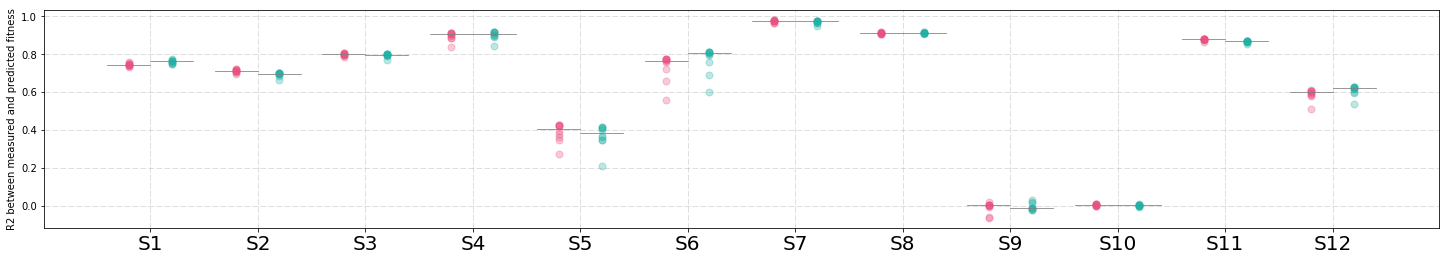

In [33]:
ax=plt.figure(figsize=[25,4])
for i, chunk in enumerate(chunks):
    plt.plot([i+1-0.2]*10,r2_val[chunk],'ok',alpha=0.3,ms=7,color='#E95280')
    plt.plot([i+1-0.4,i+1],[np.median(r2_val[chunk])]*2,color='gray',lw=0.8)
    plt.plot([i+1+0.2]*10,r2_train[chunk],'o',alpha=0.3,ms=7,color='#23B1A5')
    plt.plot([i+1,i+1.4],[np.median(r2_train[chunk])]*2,color='gray',lw=0.8)
    plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
    plt.xticks([x for x in range(1,13)],chunks,fontsize=20)
    plt.ylabel('R2 between measured and predicted fitness')
plt.savefig('../tmp/train_val_acc.pdf')

#### 2.2. Making sure that all fitness potentials correlate negatively with fitness by multiplying weights and fitness potentials by -1

In [34]:
for chunk in chunks:

    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    if R<0:
        fitness_potential[chunk]*=-1
        weights[chunk]*=-1
        
    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    print chunk, '\t', R

S1 	0.796132505599
S2 	0.809261293979
S3 	0.806858042659
S4 	0.847882510721
S5 	0.571985702411
S6 	0.837828856794
S7 	0.838452835287
S8 	0.807163272868
S9 	0.921479465828
S10 	0.926128563546
S11 	0.894697567978
S12 	0.682046148882


#### 2.3. Plotting

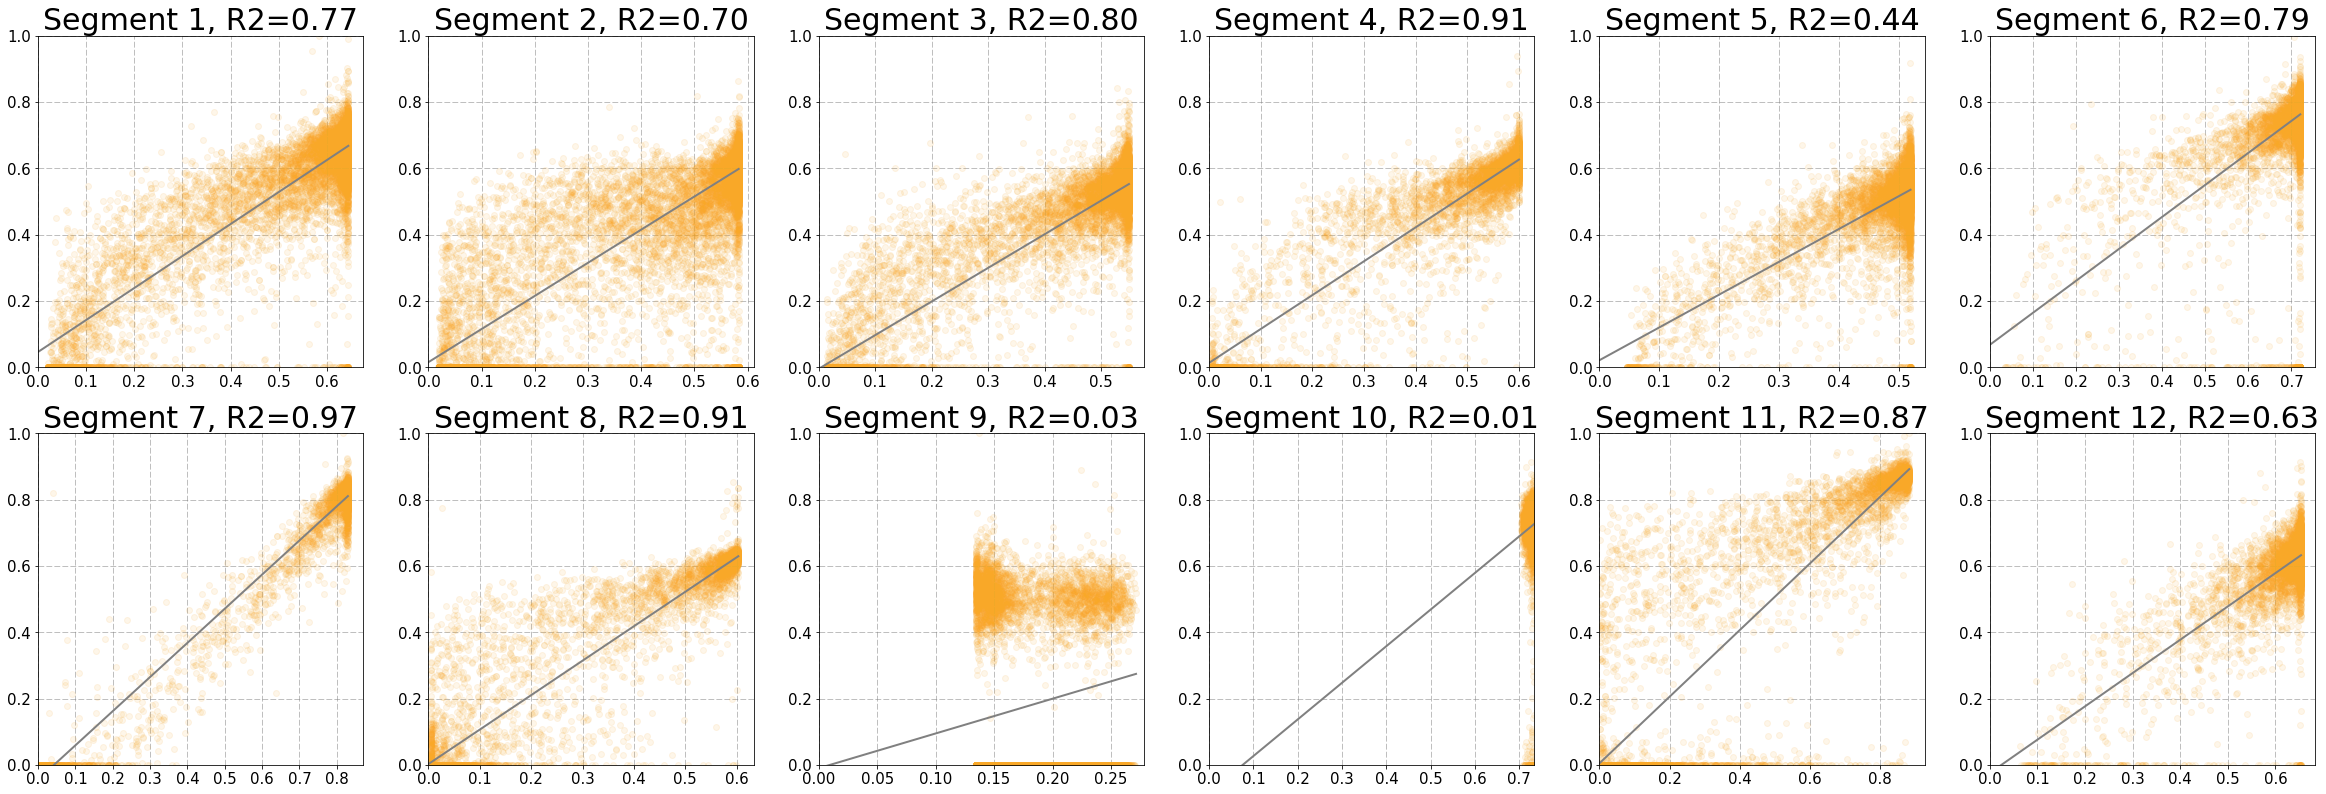

In [41]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred,y.flatten())
    
    plt.subplot(2,6,count)
    plt.subplots_adjust(top = 0.8,right=1.5)
    plt.title('Segment '+chunk[1:]+', R2=%.2f'% r_value**2, fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.plot(predicted[chunk][:10000], true[chunk][:10000], 'o', alpha=0.1,color='#F9A828')
    plt.ylim(0,1)
    plt.xlim(0,)
    f=lambda x: slope*x+intercept
    x=np.array([0,max(predicted[chunk][:10000])])
    plt.plot(x, f(x), color='gray',lw=2)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    count+=1
    
plt.savefig('../tmp/predicted_true.png', bbox_inches = 'tight')

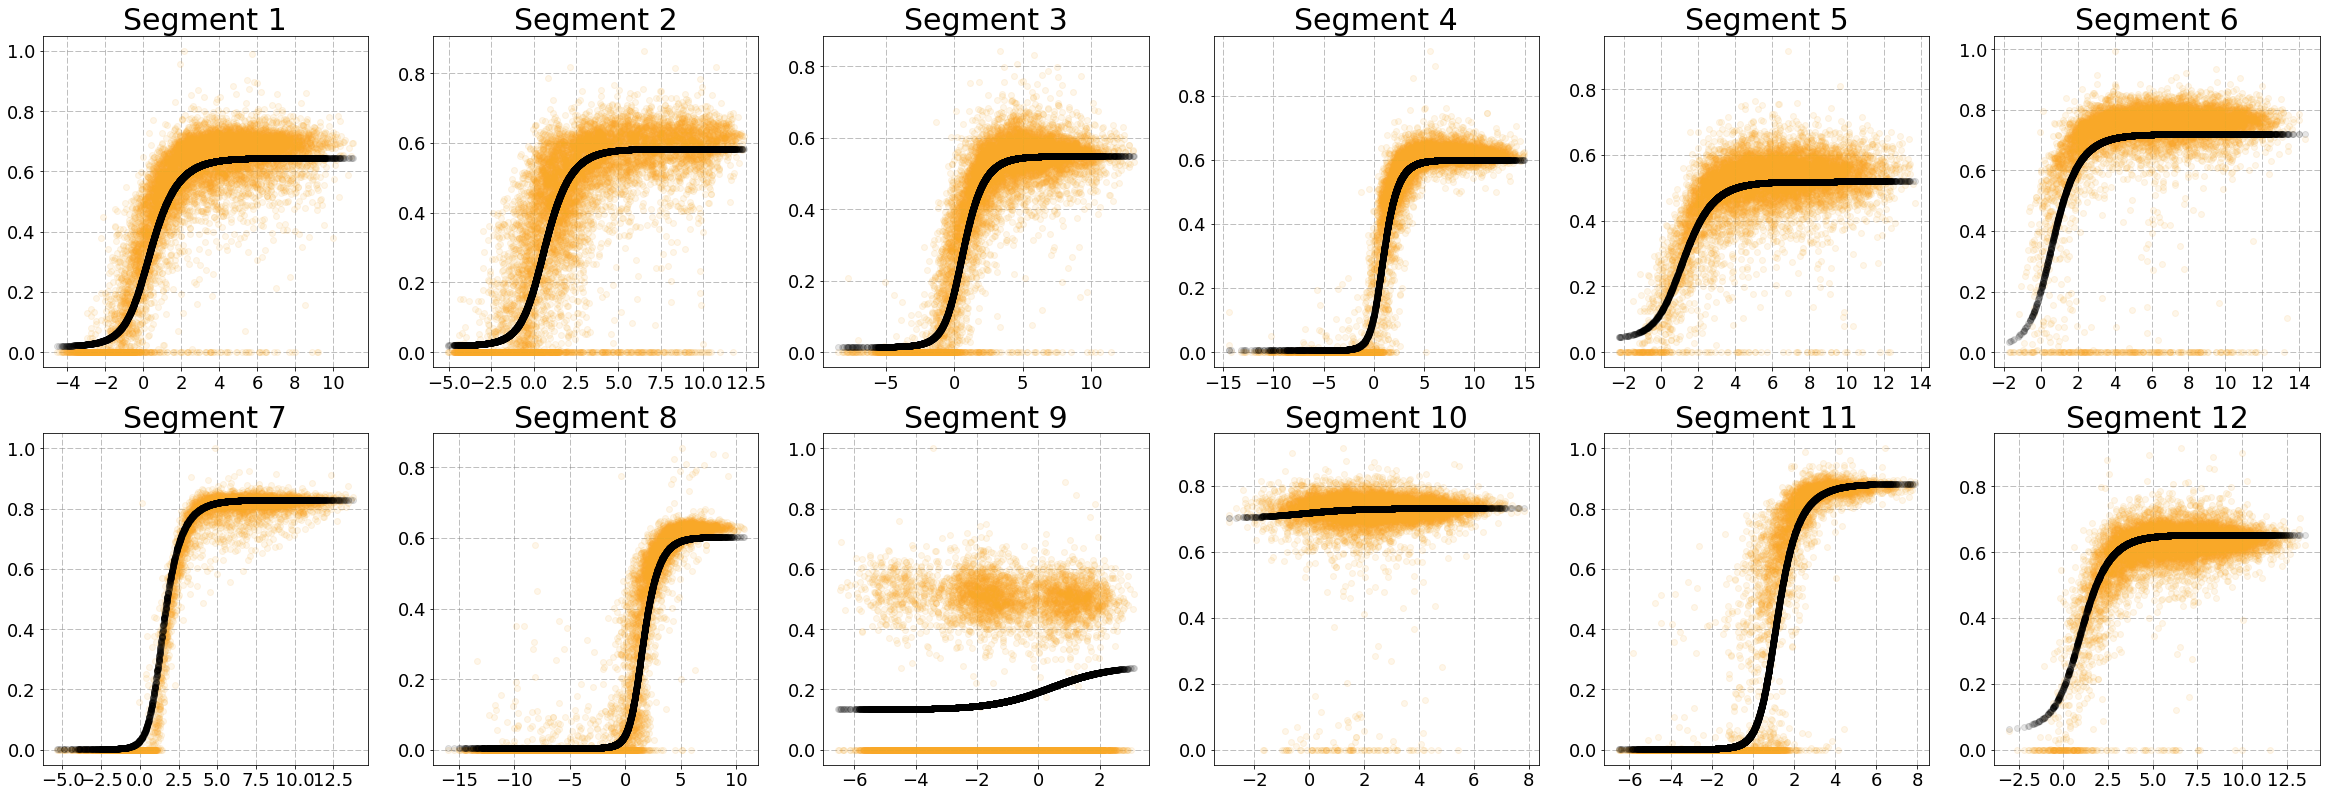

In [42]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(2,6,count)
    plt.subplots_adjust(top = 0.8,right=1.5)
    plt.title('Segment '+chunk[1:],fontsize=30)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.plot(X, Y, 'o', alpha = 0.1, color='#F9A828')
    plt.plot(X, predicted[chunk][:10000], 'o', c='k', alpha = 0.1)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    count+=1
    
plt.savefig('../tmp/fp_fitness.png', bbox_inches = 'tight')

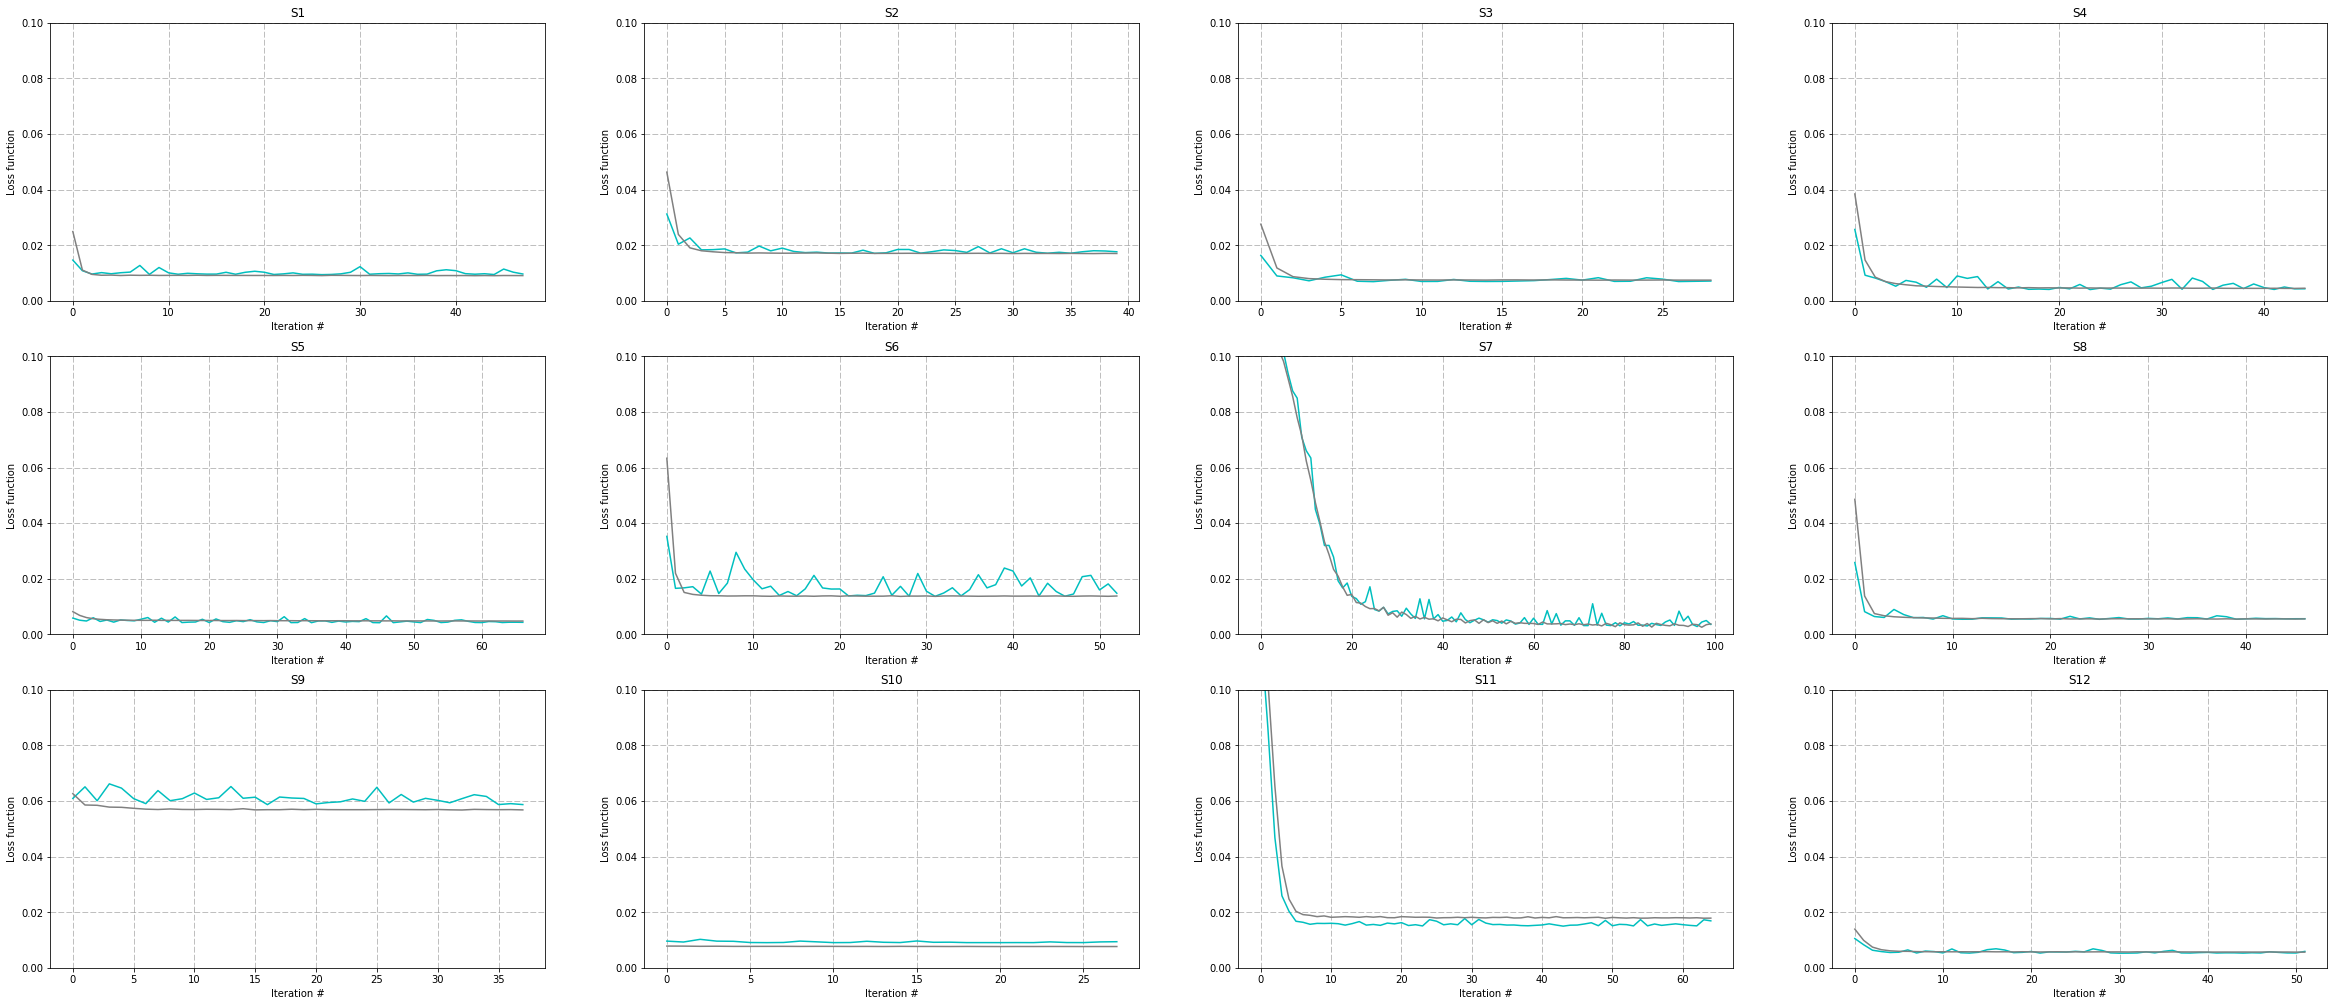

In [8]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['val_loss'], 'c')
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['loss'], 'gray')
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    plt.ylim(0, 0.1)
    count+=1

#### 2.4. Extracting residuals

In [22]:
residualsDF = {}

for chunk in chunks:
    residualsDF[chunk] = pd.DataFrame(predicted[chunk] - true[chunk], index = aa_seq[chunk])

    residualsDF[chunk]['fitnessPotential'] = fitness_potential[chunk]
    residualsDF[chunk]['observed'] = true[chunk]
    residualsDF[chunk].columns = ['predictedMinusObserved', 'fitnessPotential', 'observed']
    residualsDF[chunk].to_csv('../residuals/' + chunk + '.csv', sep=',')

#### 2.5. Extracting weights

In [23]:
weightsDF = {}

for chunk in chunks:
    weightsDF[chunk] = pd.DataFrame(weights[chunk], index = unique_mutations[chunk], columns=['weight'])
    weightsDF[chunk].to_csv('../weights/'+chunk+'.csv', sep=',')

# 3. Checking correlations

### 3.1. Correlations prediction vs observed + Lucas's values

In [24]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y.flatten(),y_pred)
    r_values.append(r_value)
    
lucas = [0.76386, 0.62877, 0.80256, 0.91289, 0.49342, 0.15075, 0.97532, 0.88078, 0.01069, 0.0096183, 0.81741, 0.54172]

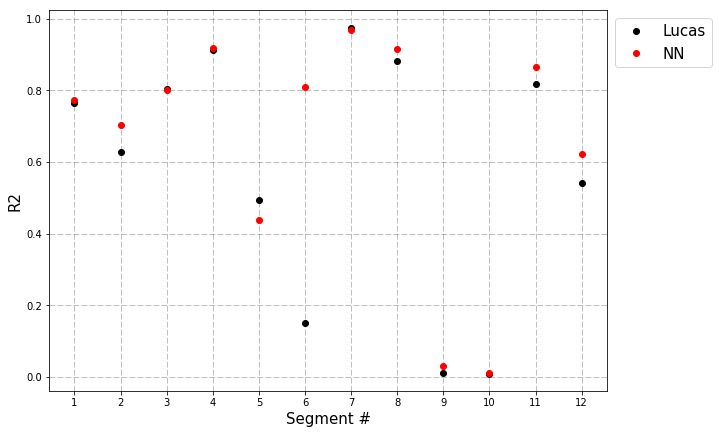

In [25]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], lucas, 'ok', label='Lucas')
plt.plot([x for x in range(1, 13)], [x**2 for x in r_values], 'or', label='NN')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.ylabel('R2', fontsize=15)
plt.xticks([x for x in range(1,13)]);

In [27]:
zip(chunks,[x**2 for x in r_values])

[('S1', 0.77235733930533168),
 ('S2', 0.70330070951837143),
 ('S3', 0.80188706786351416),
 ('S4', 0.91715152595775229),
 ('S5', 0.43676834886214877),
 ('S6', 0.80979099872822802),
 ('S7', 0.96957167235457231),
 ('S8', 0.91455573202536977),
 ('S9', 0.030980640508634298),
 ('S10', 0.009944457358705458),
 ('S11', 0.86625970286060194),
 ('S12', 0.62351136355476633)]